In [4]:
#подключение библиотек
import numpy as np
import cv2 as cv
from math import pi, log10, sqrt, sin, cos, tan, atan, ceil
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 18

## Введение

Цель работы - найти центр круглой печати на изображении. Входными данными является изображение, на котором присутствует круглая печать. В постановке задачи неявно выдвинуто предположение, что на изображении имеется объект, который является осесимметричным. Или, более того, на изображении иеются достаточное количество концентрических окружностей. В более общем случае вместо круглой печати может выступать любой объект, содержащий в себе достаточное количество концентрических окружностей (колесо, монета, радужка глаза, мяч).

Рассматривается два алгоритма нахождения центра объекта: основанный на градиенте и основанный на структурном тензоре. Алгоритм нахождения реперной точки следующий:
1. В каждой точке изображения на основе градиента или структурного тензора определить вектор "направления".
2. Создать "пустое" изображение того же размера, что и исходное
3. Через каждую точку пустого изображения "прочертить" прямую в том направлении, которое указано в соответствующей точке исходного изображения. Чтобы нарисованные прямые не перекрывали друг друга, пиксели вдоль прямой стоит не обновлять, а инкрементировать на определенную величину (например 1) или на некоторый вес, определяемый каким-либо способом для данной прямой
4. Каждый пиксель в вспомогательном изображении будет равен сумме весов, проходящих через нее прямых. Таким образом, центром объекта будет выступать аргмаксимум яркости вспомогательного изображения

## Загрузка изображения и его обработка

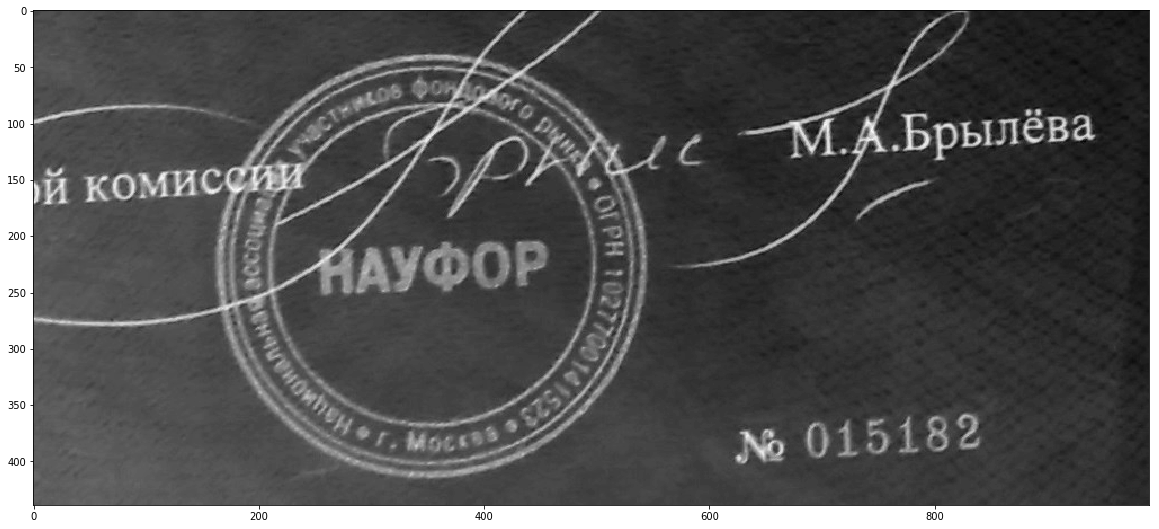

In [5]:
#load image
img_stamp_color = cv.imread('stamp6.jpg')
img_stamp_color = cv.cvtColor(img_stamp_color, cv.COLOR_BGR2RGB)
img_stamp = cv.cvtColor(img_stamp_color, cv.COLOR_RGB2GRAY)
img_stamp = cv.bitwise_not(img_stamp)

#cv.imshow('stamp', img_stamp)
#k = cv.waitKey(0)
plt.imshow(img_stamp, cmap='gray');

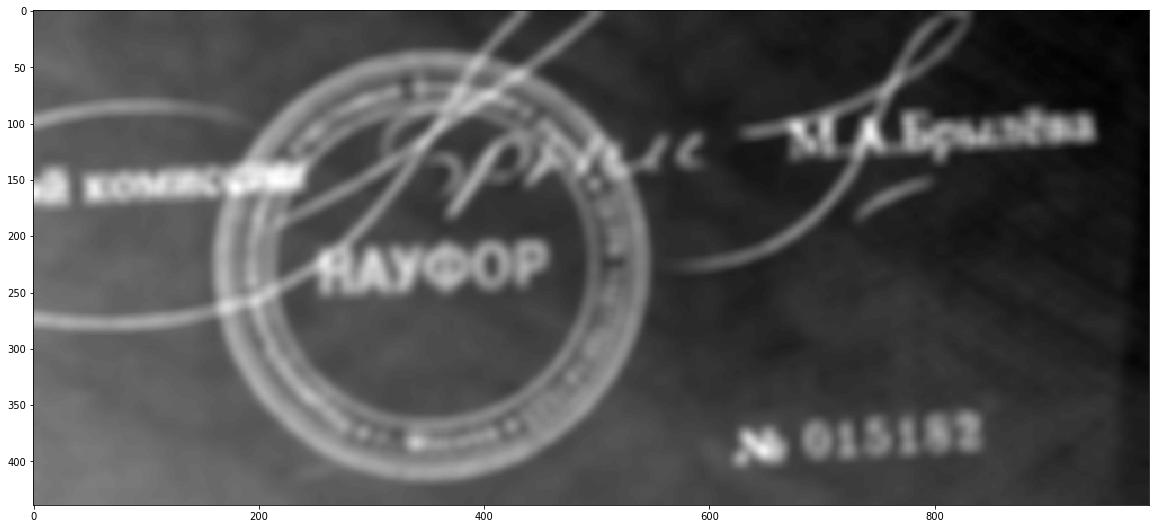

In [6]:
#image blur
img_stamp_blur = cv.GaussianBlur(img_stamp, ksize=(17,17), sigmaX=5, sigmaY=5)

#cv.imshow('blur stamp', img_stamp_blur)
#k = cv.waitKey(0)
plt.imshow(img_stamp_blur, cmap='gray');

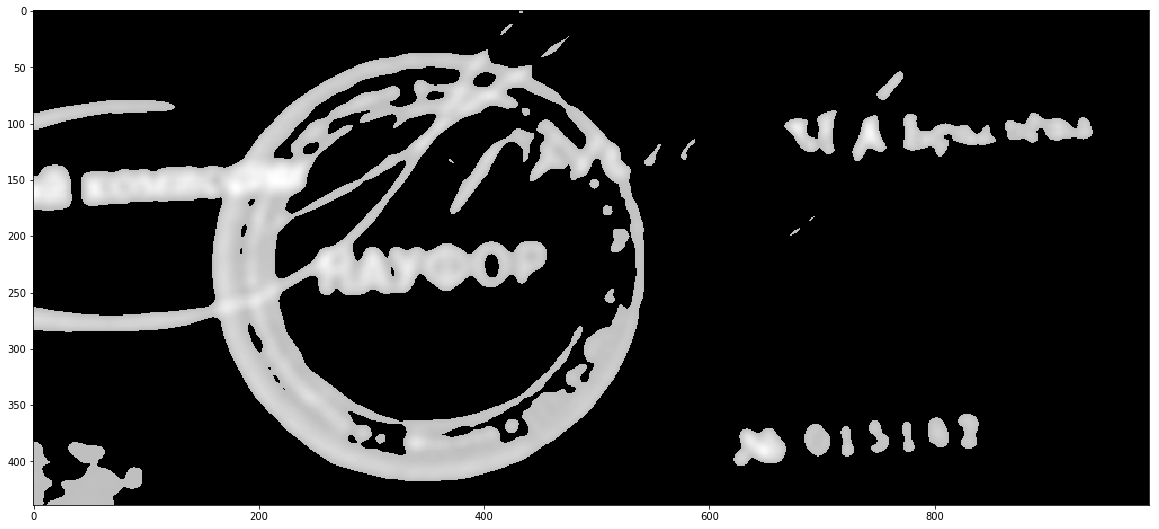

In [7]:
#image thresholding
#window = 7
#C = -30

#img_stamp_bin = cv.adaptiveThreshold(img_stamp, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, window, C)
ret, img_stamp_blur_bin = cv.threshold(img_stamp_blur, 150, 255, cv.THRESH_TOZERO)

#cv.imshow('adaptive thresholding stamp', img_stamp_blur_bin)
#k = cv.waitKey(0)
plt.imshow(img_stamp_blur_bin, cmap='gray');

## Дополнительные функции

Напишем несколько дополнительных функций, которые будут необходимы в дальнейшем. Как упоминалось ранее, пиксели вдоль прямой следует инкрементировать на некоторую величину, а не обновлять значения в этих пикселях.

## Функиця инкремента значений вдоль прямой

In [8]:
#вдоль отрезка от pt1 до pt2 увеличивает яркость пикселя на dcolor
#тот же алгоритм Брезенхема, только инкрементирует значение в пикселе, а не выставляет новое
def straight(img, pt1, pt2, dcolor):
    dx = pt2[0]-pt1[0]
    dy = pt2[1]-pt1[1]

    sign_x = 1 if dx>0 else -1 if dx<0 else 0
    sign_y = 1 if dy>0 else -1 if dy<0 else 0

    if dx < 0: dx = -dx
    if dy < 0: dy = -dy

    if dx > dy:
        pdx, pdy = sign_x, 0
        es, el = dy, dx
    else:
        pdx, pdy = 0, sign_y
        es, el = dx, dy

    x, y = pt1[0], pt1[1]

    error, t = el/2, 0        

    img[x,y] += dcolor

    while t < el:
        error -= es
        if error < 0:
            error += el
            x += sign_x
            y += sign_y
        else:
            x += pdx
            y += pdy
        t += 1
        img[x,y] += dcolor

## Направление прямой на основе градиента

Для нахождения направлений на исходном изображении так же напишем отдельные функции. Первый способ - это нахождение направлений на основе градиента яркости изображения. Функция находит градиент вдоль оси Ox и оси Oy, используя оператор Собеля. После вычисляется угол наклона градиента к оси Ox в каждой точке. Возвращается матрица со значениями этих углов

In [9]:
#направление на основе вектора градиента
def calcGV(inputIMG):
    img = inputIMG.astype(np.float32)
    # GV components calculation (start)
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    # GV components calculations (stop)
    
    # orientation angle calculation (start)
    imgOrientationOut = cv.phase(imgDiffX, imgDiffY, angleInDegrees = False)
    imgOrientationOut = imgOrientationOut % pi #[0,pi]
    # orientation angle calculation (stop)
    
    return imgOrientationOut

## Направление пямой на основе структурного тензора

Второй способ - это нахождение направлений на основе структурного тензора Яне. Структурный тензор представляет из себя матрицу следующего вида

<center> $J = \begin{bmatrix}
                  J_{11} & J_{12} \\
                  J_{21} & J_{22}
              \end{bmatrix}$ </center>

где $J_{11} = M[Z_x^2]$, $J_{22} = M[Z_y^2]$, $J_{12} = J_{21} = M[Z_xZ_y]$, $M[]$ - математическое ожидание (в нашем случае, например, среднее в гауссовом окне $w$), $Z_x$, $Z_y$ - частные производные изображения по $x$ и $y$

Данная матрица вычисляется для каждой точки изображения. Она имеет неотрицательные собственные значения. Собственный вектор, соответствующий наибольшему собственному значению, будет направлен перпендикулярно изменению градиента изображения. Угол наклона данного вектора к оси Ox вычисляется следующим образом

<center> $ \alpha = \frac{1}{2} \arctan \frac{2J_{12}}{J_{22}-J_{11}} $ </center>

и возвращается матрица со значениями посчитанных углов

In [10]:
#направление на основе структурного тензора
def calcGST(inputIMG, w):
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w,w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w,w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w,w))
    # GST components calculations (stop)
    
    # eigenvalue calculation (start)
    # lambda1 = J11 + J22 + sqrt((J11-J22)^2 + 4*J12^2)
    # lambda2 = J11 + J22 - sqrt((J11-J22)^2 + 4*J12^2)
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = tmp1 + tmp4    # biggest eigenvalue
    lambda2 = tmp1 - tmp4    # smallest eigenvalue
    # eigenvalue calculation (stop)
    
    # Coherency calculation (start)
    # Coherency = (lambda1 - lambda2)/(lambda1 + lambda2)) - measure of anisotropism
    # Coherency is anisotropy degree (consistency of local orientation)
    ##imgCoherencyOut = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    # Coherency calculation (stop)
    
    # orientation angle calculation (start)
    # tan(2*Alpha) = 2*J12/(J22 - J11)
    # Alpha = 0.5 atan2(2*J12/(J22 - J11))
    imgOrientationOut = cv.phase(J22 - J11, 2.0*J12, angleInDegrees = False)
    imgOrientationOut = (pi/2 - 0.5*imgOrientationOut) % pi #[0,pi]
    # orientation angle calculation (stop)
    
    return imgOrientationOut

## Функция прорисовки линий по матрице углов этих линий

Создадим функцию, которая принимает матрицу значений углов в каждой точке и "чертит" прямую на пустом изображении через эту точку с тем наклоном, который "записан" в этой точке. Функция возвращает изображение с нарисованными прямыми. Для ускорения работы можно "пробегать" не каждую точку, а с некоторым шагом step.

In [11]:
#attention! O(n^3)

#рисуем линию вдоль прямой по матрице углов
def draw_lines(alpha_matrix, step=1):
    img_lines = np.zeros(alpha_matrix.shape)

    y_max, x_max = alpha_matrix.shape
    y_max, x_max = y_max-1, x_max-1

    for i in range(0,y_max+1,step): #проходим по строкам
        for j in range(0,x_max+1,step): #проходим по столбцам
            x0 = j
            y0 = i
            alpha = alpha_matrix[i,j]

            #находим точку пересечения с осями (точки начала и конца отрезка, соединяющие края изображения)
            eps = 1e-2
            if abs(alpha)>eps and abs(pi/2-alpha)>eps and abs(pi-alpha)>eps and abs(3*pi/2-alpha)>eps: #чтобы не рисовать вериткальные и горизонтальные линии
                tgalpha = tan(alpha) #направление вдоль линий, поэтому берем tan
                
                P1 = (0, int(tgalpha*(0-x0)+y0))
                P2 = (x_max, int(tgalpha*(x_max-x0)+y0))
                P3 = (int(1/tgalpha*(0-y0)+x0), 0)
                P4 = (int(1/tgalpha*(y_max-y0)+x0), y_max)

                points_cand = [P1, P2, P3, P4]
                points_best = []
                for point in points_cand:
                    if 0<=point[0]<=x_max:
                        if 0<=point[1]<=y_max:
                            points_best.append(point)

                pt1, *gb, pt2 = sorted(points_best)
                
                #поменяем местами координату x(столбцы) и y(строки), т.к. функция line
                #принимает точки с координатами (строка, столбец)
                pt1 = (pt1[1], pt1[0])
                pt2 = (pt2[1], pt2[0])

                #рисуем линию по направлению производной
                straight(img_lines, pt1, pt2, 1)

    return img_lines

## Проверка алгоритма

In [12]:
#вычисляем направления на основе градиента и структурного тензора
imgOrientation_GV = calcGV(img_stamp_blur)
imgOrientation_GST = calcGST(img_stamp_blur, 7)

In [13]:
%%time
#attention! O(n^3)

#"чертим" линии на основе градиента (матрица imgOrientation_GV)
img_line_GV = draw_lines(imgOrientation_GV, 3)

Wall time: 10.2 s


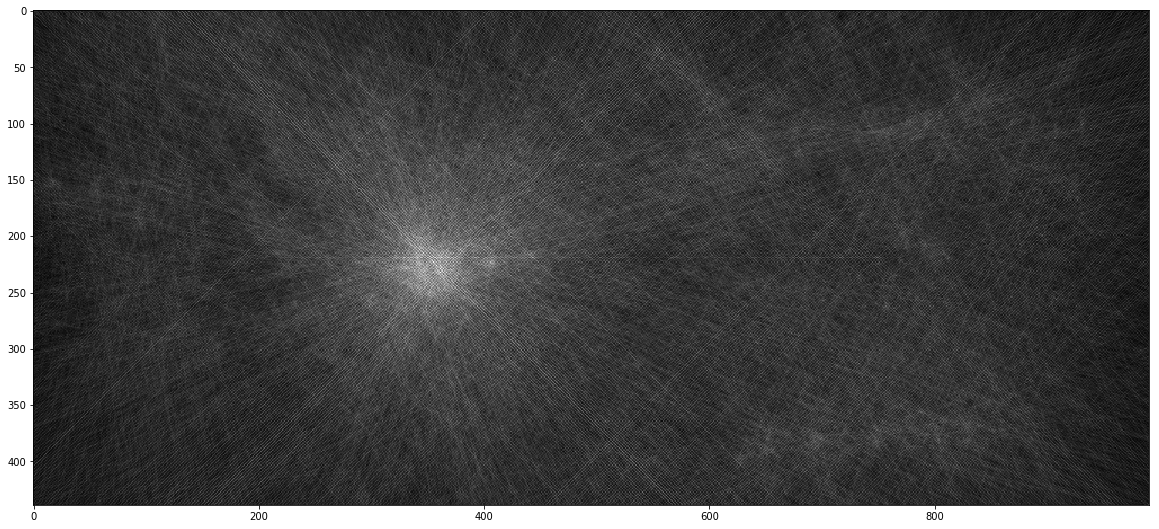

In [14]:
#полученное изображение "начерченных" линий на основе градиента
img_line_GV = cv.normalize(img_line_GV, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

#cv.imshow('line GV', img_line_GV)
#k = cv.waitKey(0)
plt.imshow(img_line_GV, cmap='gray');

In [15]:
#center
i = img_line_GV.argmax() // img_line_GV.shape[1]
j = img_line_GV.argmax() % img_line_GV.shape[1]
print('размер изображения:', img_line_GV.shape)
print('центр объекта:', (i,j))

размер изображения: (439, 991)
центр объекта: (223, 355)


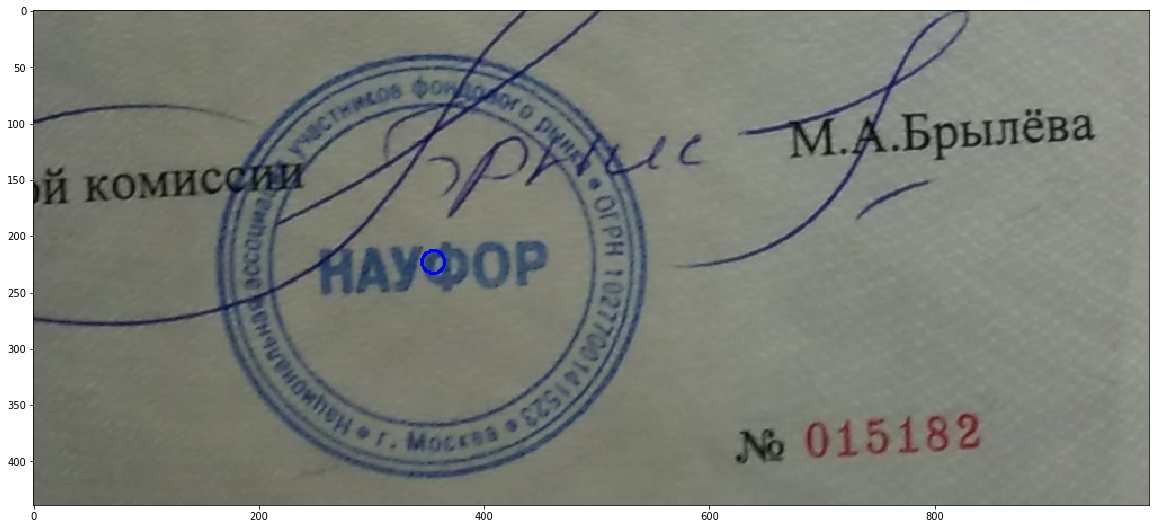

In [17]:
#найденный центр объекта на исходном изображении
cv.circle(img_stamp_color, (j,i), 10, (0,0,255), 2, 0)
plt.imshow(img_stamp_color);

In [18]:
%%time
#attention! O(n^3)

#"чертим" линии на основе структурного тензора (матрица imgOrientation_GST)
img_line_GST = draw_lines(imgOrientation_GST, 3)

Wall time: 18.5 s


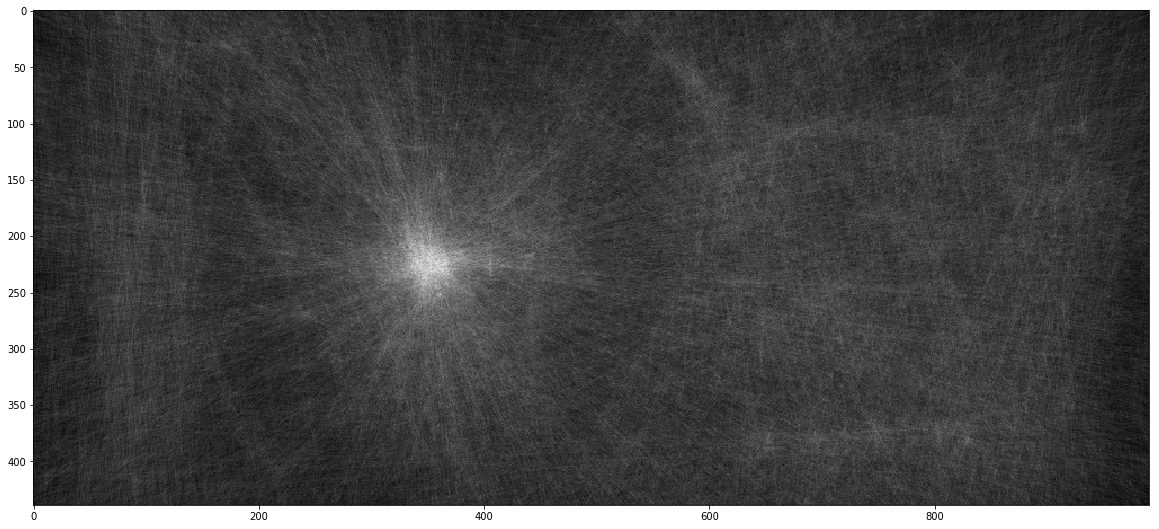

In [19]:
#полученное изображение "начерченных" линий на основе структурного тензора
img_line_GST = cv.normalize(img_line_GST, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

#cv.imshow('line GST', img_line_GST)
#k = cv.waitKey(0)
plt.imshow(img_line_GST, cmap='gray');

In [20]:
#center
i = img_line_GST.argmax() // img_line_GST.shape[1]
j = img_line_GST.argmax() % img_line_GST.shape[1]
print('размер изображения:', img_line_GST.shape)
print('центр объекта:', (i,j))

размер изображения: (439, 991)
центр объекта: (222, 341)


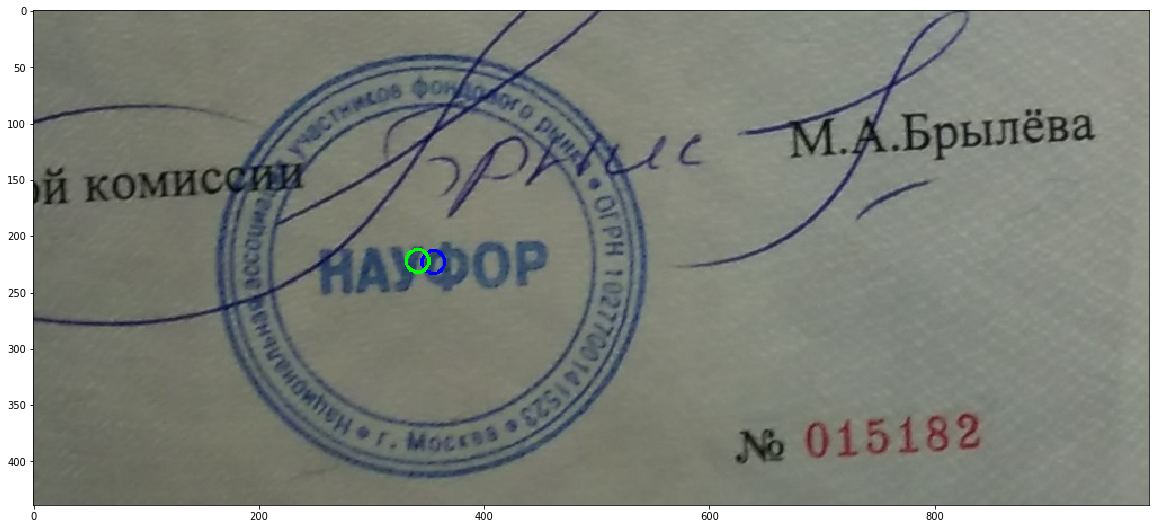

In [21]:
#найденный центр объекта на исходном изображении
cv.circle(img_stamp_color, (j,i), 10, (0,255,0), 2, 0)
plt.imshow(img_stamp_color);

## Использование преобразования Хафа

Алгоритм, основанный на "рисовании" линий имеет сложность $O(n^3)$ ($n^2$ точек и для каждой точки "чертить" линию за $O(n)$). Его можно ускорить, если использовать быстрое преобразование Хафа. Для этого будем не "чертить" линию через точку, а находить параметры этой прямой в $(s,t)$ параметризации. Преимущественно вертикальные и горизонтальные прямые будем рассматривать отдельно. Понятно, что если наше изображение имеет размер $(width, height)$, то для преимущественно горизонтальных прямых параметр $s \in [-width, height+width]$, а параметр $t\in[-width,width]$. Для преимущественно вертикальных прямых $s \in [-height, width+height]$, $t\in[-height,height]$

![title](coef.jpg)

Применим быстрое преобразование Хафа для пространства коэффициентов и найдем аргмаксимум полученного образа. Данный аргмаксимум определяет в пространстве коэффициентов наилучшую прямую, интеграл через который максимален. Данная прямая в пространстве коэффициентов может быть задана своими крайними точками $(s_1,t_1)$ и $(s_2,t_2)$. Она однозначно определяет точку в исходном изображении, которая будет искомым центром объекта.

Так как преимущественно горизонтальные и вертикальные прямые рассматривались отдельно, то есть у нас два изображения с пространством коэффициентов, то и в конечном итоге точки мы получим две, которые, возможно, не совпадут. Чтобы этого избежать, немного модифицируем процесс. Преимущественно горизонтальные прямые хорошо определяют центр объекта по вертикали и наоборот, преимущественно вертикальные прямые хорошо определяют центр объекта по горизонтали. Поэтому, в пространстве коэффициентов найдем точку пересечения наилучшей прямой, которую мы определили двумя точками $(s_1,t_1)$ и $(s_2,t_2)$ с прямой $t=0$, а вернее найдем абсциссу этой точки. Так как у нас два изображения пространств коэффициентов, то и абсцисс мы получим две, а они как раз и будут координатами центра нашего объекта с точностью до сдвига СК пространств коэффициентов.

## Функция заполнения пространства коэффициентов линий по матрице углов этих линий

In [22]:
def calculate_Hough(alpha_matrix):
    height, width = alpha_matrix.shape
    img_mostly_horizontal = np.zeros((2*width, 2*width+height))
    img_mostly_vertical = np.zeros((2*height, 2*height+width))

    y_max, x_max = alpha_matrix.shape
    y_max, x_max = y_max-1, x_max-1

    for i in range(y_max+1): #проходим по строкам
        for j in range(x_max+1): #проходим по столбцам
            x0 = j
            y0 = i
            alpha = alpha_matrix[i,j]

            #находим точку пересечения с осями (точки начала и конца отрезка, соединяющие края изображения)
            eps = 1e-2
            if abs(alpha)>eps and abs(pi/2-alpha)>eps and abs(pi-alpha)>eps and abs(3*pi/2-alpha)>eps: #чтобы не рисовать вериткальные и горизонтальные линии
                tgalpha = tan(alpha) #направление вдоль линий, поэтому берем tan
                
                if abs(tgalpha) <= 1: #т.е. преимущественно горизонтальная прямая
                    P1 = (0, int(tgalpha*(0-x0)+y0))
                    P2 = (x_max, int(tgalpha*(x_max-x0)+y0))
                    
                    s = P1[1] + width
                    t = P2[1]-P1[1] + width
                    
                    img_mostly_horizontal[t,s] += 1
                else: #т.е. преимущественно вертикальная прямая
                    P3 = (int(1/tgalpha*(0-y0)+x0), 0)
                    P4 = (int(1/tgalpha*(y_max-y0)+x0), y_max)
                    
                    s = P3[0] + height
                    t = P4[0]-P3[0] + height
                    
                    img_mostly_vertical[t,s] += 1

    return img_mostly_horizontal, img_mostly_vertical

## Функция нахождения координат центра объекта, используя пространство коэффициентов

In [23]:
def find_center(img_coef_mostly_horizontal, img_coef_mostly_vertical):
    img_coef_mostly_horizontal = img_coef_mostly_horizontal.astype('uint8')
    y_max, x_max = img_coef_mostly_horizontal.shape
    width = y_max//2 #width of original img
    height = x_max - y_max #height of original img
    y_max, x_max = y_max-1, x_max-1 #for calculate coord

    lines_H = cv.HoughLines(img_coef_mostly_horizontal,1,np.pi/180,1,max_theta=pi/2-1e-2) #надо БПХ и аргмакс по хорошему
    rho, theta = lines_H[0][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    tgalpha = tan(theta-pi/2)

    P3 = (int(1/tgalpha*(0-y0)+x0), 0)
    P4 = (int(1/tgalpha*(y_max-y0)+x0), y_max)

    center_row = (P3[0]+P4[0]+1)//2 - width

    
    img_coef_mostly_vertical = img_coef_mostly_vertical.astype('uint8')
    y_max, x_max = img_coef_mostly_vertical.shape
    height = y_max//2 #height of original img
    width = x_max - y_max #width of original img
    y_max, x_max = y_max-1, x_max-1 #for calculate coord

    lines_V = cv.HoughLines(img_coef_mostly_vertical,1,np.pi/180,1,max_theta=pi/2-1e-2) #надо БПХ и аргмакс по хорошему
    rho, theta = lines_V[0][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    tgalpha = tan(theta-pi/2)

    P3 = (int(1/tgalpha*(0-y0)+x0), 0)
    P4 = (int(1/tgalpha*(y_max-y0)+x0), y_max)

    center_col = (P3[0]+P4[0]+1)//2 - height
    
    return center_col, center_row

In [26]:
%%time

#находим координаты центра объекта, используя пространство коэффициентов
img_coef_H, img_coef_V = calculate_Hough(imgOrientation_GST)
j, i = find_center(img_coef_H, img_coef_V)

Wall time: 4.43 s


In [27]:
#center
print('размер изображения:', img_stamp.shape)
print('центр объекта:', (i,j))

размер изображения: (439, 991)
центр объекта: (230, 350)


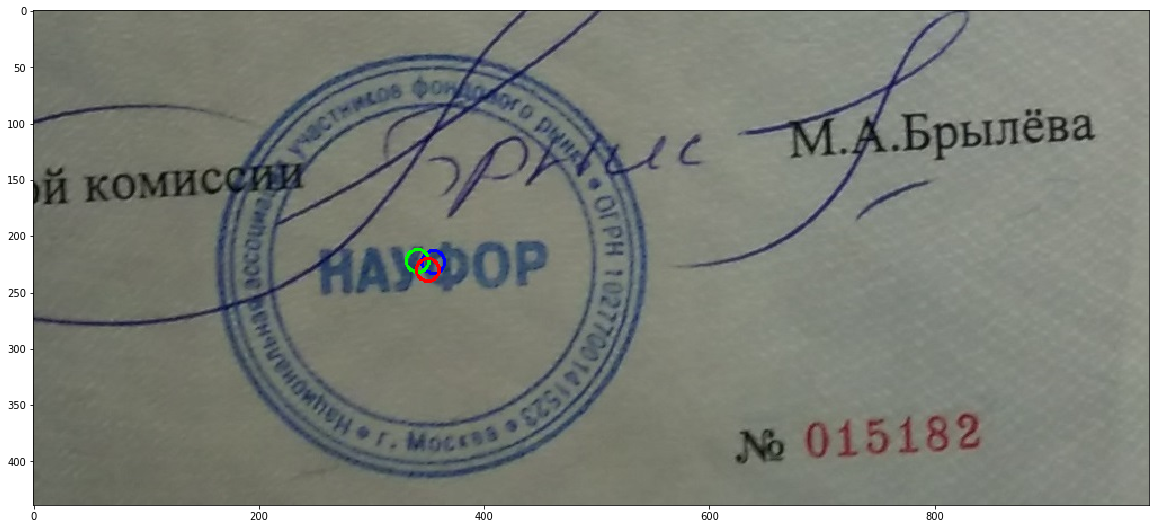

In [28]:
#найденный центр объекта на исходном изображении
cv.circle(img_stamp_color, (j,i), 10, (255,0,0), 2, 0)
plt.imshow(img_stamp_color);